<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Singapore Housing Price Prediction

## Table of Contents
1. [Problem Statement](#1.-Problem-Statement)  
2. [Import Libraries and Datasets](#2.-Import-Libraries-and-Datasets)   
3. [Feature Engineering](#3.-Feature-Engineering)  
4. [Modeling](#4.-Modeling)  
5. [Model Evaluation](#5.-Model-Evaluation)  
6. [Conclusion and Recommendation](#6.-Conclusion-and-Recommendation)  
7. [Limitations](#7.-Limitations)
8. [Future Steps](#8.-Future-Steps)

# 1. Problem Statement

As data scientists working for a real estate agent, our goal is to empower prospective householders and sellers to make informed decisions about property purchases and sales. Our main objectives are:

**- Use Singapore public housing data from 2012 to 2021 to create a regression model that predicts the resale price of HDB flats in Singapore.**

**- Identify the top 5 features that have the greatest positive correlation to the resale price so that buyers and sellers can take this information into consideration.**

This notebook covered the feature engineering, modeling, evaluation, conclusion and recommendation phase. 

# 2. Import Libraries and Datasets

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew 
from scipy.special import boxcox1p

import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
df_train = pd.read_csv("../datasets/train_cleaned.csv")
df_test = pd.read_csv("../datasets/test_cleaned.csv")

In [3]:
#Backup the train and test data
df_train_copy = copy.copy(df_train)
df_test_copy = copy.deepcopy(df_test)

In [4]:
#Backup the test id
df_test_id = pd.read_csv("../datasets/test.csv", dtype={'postal': 'object'})['id']
df_test_copy['id'] = df_test_id

In [5]:
#In order to proceed the feature engineering for both train and test set, merge them together first
ntrain = df_train.shape[0] 
ntest = df_test.shape[0] 
y_train = df_train['resale_price'] #Keep the target feature of train dataset
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['resale_price'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (167371, 47)


In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167371 entries, 0 to 167370
Data columns (total 47 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   town                       167371 non-null  object 
 1   flat_type                  167371 non-null  object 
 2   flat_model                 167371 non-null  object 
 3   tranc_year                 167371 non-null  int64  
 4   tranc_month                167371 non-null  int64  
 5   mid_storey                 167371 non-null  int64  
 6   floor_area_sqft            167371 non-null  float64
 7   hdb_age                    167371 non-null  int64  
 8   max_floor_lvl              167371 non-null  int64  
 9   year_completed             167371 non-null  int64  
 10  commercial                 167371 non-null  object 
 11  market_hawker              167371 non-null  object 
 12  multistorey_carpark        167371 non-null  object 
 13  precinct_pavilion          16

# 3. Feature Engineering

## 3.1 Add New Features

**Considered the numbers of mall/hawker in a larger distance included the numbers of mall/hawker in a smaller distance, new features can be created as below:** 

In [7]:
all_data['mall_500m_to_1km'] = all_data['mall_within_1km'] - all_data['mall_within_500m']
all_data['mall_1km_to_2km'] = all_data['mall_within_2km'] - all_data['mall_within_1km']

all_data['hawker_500m_to_1km'] = all_data['hawker_within_1km'] - all_data['hawker_within_500m']
all_data['hawker_1km_to_2km'] = all_data['hawker_within_2km'] - all_data['hawker_within_1km']

**Create a new feature age_of_built:**

In [8]:
all_data["age_of_built"] = all_data['tranc_year'] - all_data['year_completed']

**Transfer the int datatype of below features to str as they don't have numerical meanings:**

In [9]:
cols = ['tranc_year', 'tranc_month', 'year_completed', 'bus_interchange', 'mrt_interchange', 'pri_sch_affiliation', 'affiliation']
for col in cols:
    all_data[col] = all_data[col].astype(str)    
del cols, col

**Label encoding year and month**

In [10]:
str_cols = ['tranc_year', 'tranc_month', 'year_completed']
for col in str_cols:
    all_data[col] = LabelEncoder().fit_transform(all_data[col])

In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167371 entries, 0 to 167370
Data columns (total 52 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   town                       167371 non-null  object 
 1   flat_type                  167371 non-null  object 
 2   flat_model                 167371 non-null  object 
 3   tranc_year                 167371 non-null  int64  
 4   tranc_month                167371 non-null  int64  
 5   mid_storey                 167371 non-null  int64  
 6   floor_area_sqft            167371 non-null  float64
 7   hdb_age                    167371 non-null  int64  
 8   max_floor_lvl              167371 non-null  int64  
 9   year_completed             167371 non-null  int64  
 10  commercial                 167371 non-null  object 
 11  market_hawker              167371 non-null  object 
 12  multistorey_carpark        167371 non-null  object 
 13  precinct_pavilion          16

## 3.2 Numerical Variable Features Transformation

In [12]:
print("Skewness: %f" % y_train.skew())
print("Kurtosis: %f" % y_train.kurt())

Skewness: 1.083759
Kurtosis: 1.325540


In [13]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

#Check the skewness of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
other_room_rental,79.521010
multigen_sold,50.660446
1room_sold,43.330977
1room_rental,41.446940
2room_rental,27.034726
3room_rental,22.261928
studio_apartment_sold,15.331996
2room_sold,8.680007
mall_within_2km,4.628154
mall_1km_to_2km,3.872227


In [14]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 41 skewed numerical features to Box Cox transform


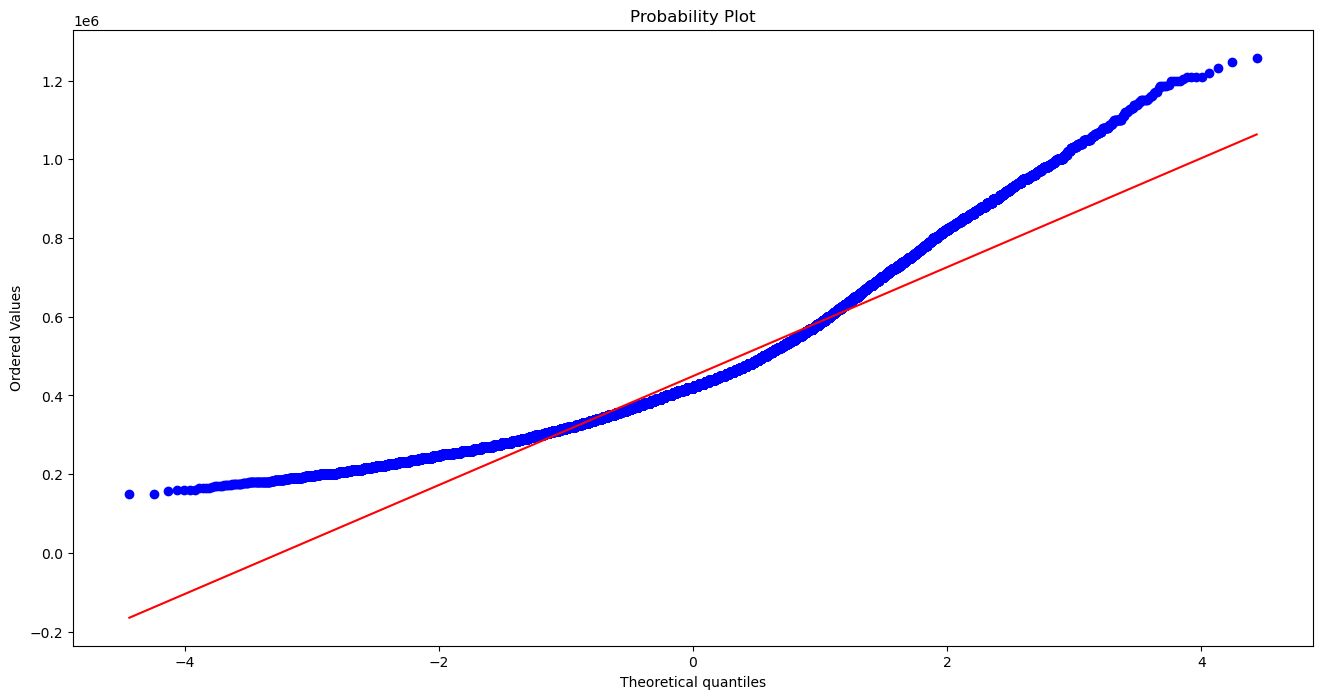

In [15]:
plt.figure(figsize=(16, 8))
res = stats.probplot(y_train, plot=plt)

/tmp/ipykernel_737/1830515789.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, fit=norm);



 mu = 12.97 and sigma = 0.30



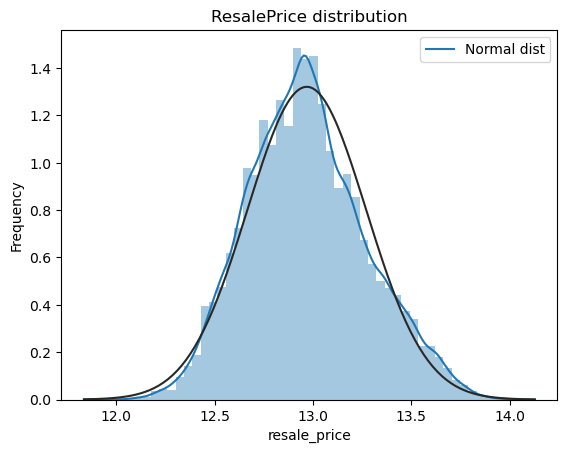

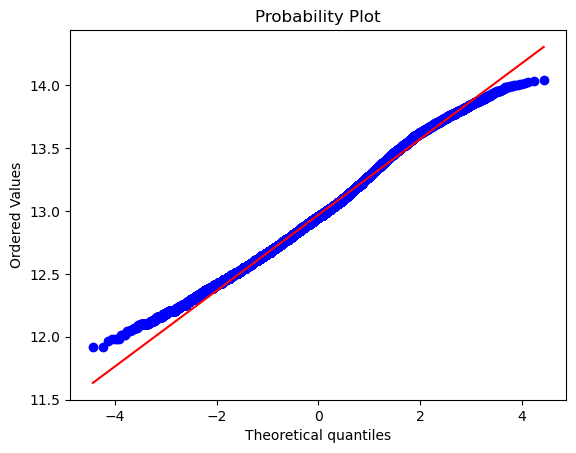

In [16]:
# Normalize Y
y_train = np.log1p(y_train)

# Plot the distribution to check the new distribution
sns.distplot(y_train, fit=norm);
plt.legend(['Normal dist'], loc='best')
plt.ylabel('Frequency')
plt.title('ResalePrice distribution')

# Get the new normal distribution parameters
(mu, sigma) = norm.fit(y_train)
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Plot QQ-plot graph
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)

## 3.3 Datatype Transformation

**The datatype of following features can be transformed from object to boolean (0/1):**
* commercial
* market_hawker
* multistorey_carpark
* precinct_pavilion
* bus_interchange
* mrt_interchange
* pri_sch_affiliation
* affiliation

In [17]:
all_data['commercial'] = all_data['commercial'].map({'Y': 1,'N': 0})
all_data['market_hawker'] = all_data['market_hawker'].map({'Y': 1,'N': 0})
all_data['multistorey_carpark'] = all_data['multistorey_carpark'].map({'Y': 1,'N': 0})
all_data['precinct_pavilion'] = all_data['precinct_pavilion'].map({'Y': 1,'N': 0})

all_data['bus_interchange'] = all_data['bus_interchange'].astype(int)
all_data['mrt_interchange'] = all_data['mrt_interchange'].astype(int)
all_data['pri_sch_affiliation'] = all_data['pri_sch_affiliation'].astype(int)
all_data['affiliation'] = all_data['affiliation'].astype(int)

In [18]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167371 entries, 0 to 167370
Data columns (total 52 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   town                       167371 non-null  object 
 1   flat_type                  167371 non-null  object 
 2   flat_model                 167371 non-null  object 
 3   tranc_year                 167371 non-null  float64
 4   tranc_month                167371 non-null  float64
 5   mid_storey                 167371 non-null  float64
 6   floor_area_sqft            167371 non-null  float64
 7   hdb_age                    167371 non-null  float64
 8   max_floor_lvl              167371 non-null  float64
 9   year_completed             167371 non-null  float64
 10  commercial                 167371 non-null  int64  
 11  market_hawker              167371 non-null  int64  
 12  multistorey_carpark        167371 non-null  int64  
 13  precinct_pavilion          16

## 3.4 One-Hot Encoding

**The following features can be one-hot encoded:**
* town
* flat_model

In [19]:
all_data['town'].unique()

array(['KALLANG/WHAMPOA', 'BISHAN', 'BUKIT BATOK', 'YISHUN', 'GEYLANG',
       'HOUGANG', 'BEDOK', 'SENGKANG', 'TAMPINES', 'SERANGOON',
       'BUKIT MERAH', 'BUKIT PANJANG', 'WOODLANDS', 'JURONG WEST',
       'TOA PAYOH', 'CHOA CHU KANG', 'SEMBAWANG', 'ANG MO KIO',
       'PASIR RIS', 'CLEMENTI', 'PUNGGOL', 'JURONG EAST', 'CENTRAL AREA',
       'QUEENSTOWN', 'BUKIT TIMAH', 'MARINE PARADE'], dtype=object)

In [20]:
len(all_data['town'].unique())

26

In [21]:
all_data['flat_model'].unique()

array(['Model A', 'Improved', 'Apartment', 'Simplified', 'New Generation',
       'Premium Apartment', 'Model A2', 'Maisonette', 'Standard', 'DBSS',
       'Terrace', 'Model A-Maisonette', 'Type S1',
       'Premium Apartment Loft', 'Adjoined flat', 'Multi Generation',
       'Type S2', 'Premium Maisonette', 'Improved-Maisonette', '2-room'],
      dtype=object)

In [22]:
len(all_data['flat_model'].unique())

20

In [23]:
all_data = pd.get_dummies(all_data, columns=['town', 'flat_model'], drop_first=True)

In [24]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167371 entries, 0 to 167370
Data columns (total 94 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   flat_type                          167371 non-null  object 
 1   tranc_year                         167371 non-null  float64
 2   tranc_month                        167371 non-null  float64
 3   mid_storey                         167371 non-null  float64
 4   floor_area_sqft                    167371 non-null  float64
 5   hdb_age                            167371 non-null  float64
 6   max_floor_lvl                      167371 non-null  float64
 7   year_completed                     167371 non-null  float64
 8   commercial                         167371 non-null  int64  
 9   market_hawker                      167371 non-null  int64  
 10  multistorey_carpark                167371 non-null  int64  
 11  precinct_pavilion                  1673

**Now all the datatypes of features for modeling are digitalized except flat type.** 

In [25]:
#Split back to Train/Test datasets
df_train = all_data[:ntrain]
df_test = all_data[ntrain:]

In [26]:
#Add the 'resale_price' column back to train set
df_train.loc[:, 'resale_price'] = y_train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 95 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   flat_type                          150634 non-null  object 
 1   tranc_year                         150634 non-null  float64
 2   tranc_month                        150634 non-null  float64
 3   mid_storey                         150634 non-null  float64
 4   floor_area_sqft                    150634 non-null  float64
 5   hdb_age                            150634 non-null  float64
 6   max_floor_lvl                      150634 non-null  float64
 7   year_completed                     150634 non-null  float64
 8   commercial                         150634 non-null  int64  
 9   market_hawker                      150634 non-null  int64  
 10  multistorey_carpark                150634 non-null  int64  
 11  precinct_pavilion                  1506

/tmp/ipykernel_737/614279243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'resale_price'] = y_train


## 3.5 Data Dictionary

**The final data has 95 columns (94 features + 1 target variable) which contains 167371 HDB flat resale records (150634 for train set and 16737 for test set) from 2012 to 2021.**

|Feature|Type|Description| 
|---|---|---|
|resale_price|float|property's resale price in Singapore dollars. This is the target variable that we are trying to predict| 
|town|uint|HDB township where the flat is located, e.g. BUKIT MERAH (one-hot encoded, 26 features)| 
|flat_model|uint|HDB model of the resale flat, e.g. Multi Generation (one-hot encoded, 20 features)| 
|flat_type|string|type of the resale flat unit, e.g. 3 ROOM (7 types in total)| 
|tranc_year|int|year of resale transaction|
|tranc_month|int|month of resale transaction| 
|mid_storey|int|median value of storey_range| 
|floor_area_sqft|float|floor area of the resale flat unit in square feet| 
|hdb_age|int|number of years from lease_commence_date to present year| 
|max_floor_lvl|int|highest floor of the resale flat| 
|year_completed|int|year which construction was completed for resale flat| 
|commercial|int|boolean value (0/1) if resale flat has commercial units in the same block| 
|market_hawker|int|boolean value (0/1) if resale flat has a market or hawker centre in the same block|
|multistorey_carpark|int|boolean value (0/1) if resale flat has a multistorey carpark in the same block|
|precinct_pavilion|int|boolean value (0/1) if resale flat has a pavilion in the same block| 
|total_dwelling_units|int|total number of residential dwelling units in the resale flat| 
|1room_sold|int|number of 1-room residential units in the resale flat| 
|2room_sold|int|number of 2-room residential units in the resale flat| 
|3room_sold|int|number of 3-room residential units in the resale flat| 
|4room_sold|int|number of 4-room residential units in the resale flat| 
|5room_sold|int|number of 5-room residential units in the resale flat| 
|exec_sold|int|number of executive type residential units in the resale flat block| 
|multigen_sold|int|number of multi-generational type residential units in the resale flat block|
|studio_apartment_sold|int|number of studio apartment type residential units in the resale flat block| 
|1room_rental|int|number of 1-room rental residential units in the resale flat block| 
|2room_rental|int|number of 2-room rental residential units in the resale flat block| 
|3room_rental|int|number of 3-room rental residential units in the resale flat block| 
|other_room_rental|int|number of "other" type rental residential units in the resale flat block|
|mall_nearest_distance|float|distance (in metres) to the nearest mall| 
|mall_within_500m|int|number of malls within 500 metres| 
|mall_within_1km|int|number of malls within 1 kilometre| 
|mall_within_2km|int|number of malls within 2 kilometres| 
|hawker_nearest_distance|float|distance (in metres) to the nearest hawker centre| 
|hawker_within_500m|int|number of hawker centres within 500 metres| 
|hawker_within_1km|int|number of hawker centres within 1 kilometre| 
|hawker_within_2km|int|number of hawker centres within 2 kilometres|
|hawker_food_stalls|int|number of hawker food stalls in the nearest hawker centre|
|hawker_market_stalls|int|number of hawker and market stalls in the nearest hawker centre|
|mrt_nearest_distance|float|distance (in metres) to the nearest MRT station|
|bus_interchange|int|boolean value (0/1) if the nearest MRT station is also a bus interchange|
|mrt_interchange|int|boolean value (0/1) if the nearest MRT station is a train interchange station|
|bus_stop_nearest_distance|float|distance (in metres) to the nearest bus stop|
|pri_sch_nearest_distance|float|distance (in metres) to the nearest primary school|
|vacancy|int|number of vacancies in the nearest primary school|
|pri_sch_affiliation|int|boolean value (0/1) if the nearest primary school has a secondary school affiliation|
|sec_sch_nearest_dist|float|distance (in metres) to the nearest secondary school|
|cutoff_point|float|PSLE cutoff point of the nearest secondary school|
|affiliation|int|boolean value (0/1) if the nearest secondary school has an primary school affiliation|
|mall_500m_to_1km|int|number of malls between 500 metres to 1km|              
|mall_1km_to_2km|int|number of malls between 1km to 2km|               
|hawker_500m_to_1km|int|number of hawkers between 500 metres to 1km|              
|hawker_1km_to_2km|int|number of hawkers between 1km to 2km|              
|age_of_built|int|number of years from tranc_year to year_completed|

# 4. Modeling

## 4.1 Baseline Score

In [27]:
base_line = round(df_train_copy['resale_price'].mean(),2)
base_score = round(np.sqrt(((df_train_copy['resale_price']- base_line)**2).mean()),2)

print(f'Baseline using the mean value of resale price from train dataset: {base_line}')
print(f'Baseline score (RMSE) with the mean value of resale price from train dataset: {base_score}')

Baseline using the mean value of resale price from train dataset: 449161.5
Baseline score (RMSE) with the mean value of resale price from train dataset: 143307.1


## 4.2 Initial setup for all 7 Models

In [28]:
def model_performance(test_data, predictions):
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    print(f'RMSE = {rmse}')

In [29]:
flat_type_list = ['1 ROOM','2 ROOM','3 ROOM','4 ROOM','5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION']

In [30]:
#Seperate the train dataframe by flat types
df_train_ft = []
for flat_type in flat_type_list:
    df = df_train[df_train['flat_type'] == flat_type]
    df_train_ft.append(df)
    print(f'{flat_type}: {len(df)}')

1 ROOM: 82
2 ROOM: 1896
3 ROOM: 39060
4 ROOM: 61136
5 ROOM: 36415
EXECUTIVE: 11989
MULTI-GENERATION: 56


In [31]:
X = []
y = []
for df in df_train_ft:
    X.append(df.drop(['resale_price', 'flat_type'],axis=1))
    y.append(df['resale_price'])

In [32]:
#Train-test split for the model of each flat type
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X[0], y[0], test_size=0.3, random_state=42)
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X[1], y[1], test_size=0.3, random_state=42)
X_train_3, X_valid_3, y_train_3, y_valid_3 = train_test_split(X[2], y[2], test_size=0.2, random_state=42)
X_train_4, X_valid_4, y_train_4, y_valid_4 = train_test_split(X[3], y[3], test_size=0.2, random_state=42)
X_train_5, X_valid_5, y_train_5, y_valid_5 = train_test_split(X[4], y[4], test_size=0.2, random_state=42)
X_train_exec, X_valid_exec, y_train_exec, y_valid_exec = train_test_split(X[5], y[5], test_size=0.3, random_state=42)
X_train_multi, X_valid_multi, y_train_multi, y_valid_multi = train_test_split(X[6], y[6], test_size=0.3, random_state=42)

**Noted that 1 ROOM and MULTI-GENERATION have few sample size, so the modeling for these two types will be done seperately.**  

In [33]:
#Create train valid dataset list for 2 ROOM to 5 ROOM and EXECUTIVE
X_train_list = [X_train_2, X_train_3, X_train_4, X_train_5, X_train_exec]
X_valid_list = [X_valid_2, X_valid_3, X_valid_4, X_valid_5, X_valid_exec]
y_train_list = [y_train_2, y_train_3, y_train_4, y_train_5, y_train_exec]
y_valid_list = [y_valid_2, y_valid_3, y_valid_4, y_valid_5, y_valid_exec]

## 4.3 Linear Regression

Linear regression is the most basic and commonly used predictive analysis. Regression estimates are used to describe data and to explain the relationship.  

$$ \huge y = \beta_0 + \beta_1 x_1 + \epsilon $$

### 4.3.1 Model_1 and Model_7 (Model_multi)

**Model_1**

In [34]:
# Instantiate pipeline object.
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('lr', LinearRegression())
])

In [35]:
# Define dictionary of hyperparameters.
pipe_params = {'ss__with_mean': [True, False], 
                 'ss__with_std': [True, False]}

In [36]:
# Instantiate our GridSearchCV object.
pipe_gridsearch = GridSearchCV(pipe, 
                                 pipe_params, 
                                 cv=5, 
                                 verbose=1)

In [37]:
pipe_gridsearch.fit(X_train_1, y_train_1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('pca', PCA(n_components=3)),
                                       ('lr', LinearRegression())]),
             param_grid={'ss__with_mean': [True, False],
                         'ss__with_std': [True, False]},
             verbose=1)

In [38]:
print(f'R2 train: {round(pipe_gridsearch.best_score_,3)}')
print(f'R2 valid: {round(pipe_gridsearch.score(X_valid_1, y_valid_1),3)}')
print(f'parameters: {pipe_gridsearch.best_estimator_}')

R2 train: 0.574
R2 valid: 0.641
parameters: Pipeline(steps=[('ss', StandardScaler(with_mean=False)),
                ('pca', PCA(n_components=3)), ('lr', LinearRegression())])


In [39]:
lr_preds = pipe_gridsearch.predict(X_valid_1)
model_performance(y_valid_1,lr_preds)

RMSE = 0.0668337655991749


**Model_7 (Model_multi)**

In [40]:
# Instantiate pipeline object.
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('lr', LinearRegression())
])

In [41]:
# Define dictionary of hyperparameters.
pipe_params = {'ss__with_mean': [True, False], 
                 'ss__with_std': [True, False]}

In [42]:
# Instantiate our GridSearchCV object.
pipe_gridsearch = GridSearchCV(pipe, 
                                 pipe_params, 
                                 cv=5, 
                                 verbose=1)

In [43]:
pipe_gridsearch.fit(X_train_multi, y_train_multi)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('pca', PCA(n_components=10)),
                                       ('lr', LinearRegression())]),
             param_grid={'ss__with_mean': [True, False],
                         'ss__with_std': [True, False]},
             verbose=1)

In [44]:
print(f'R2 train: {round(pipe_gridsearch.best_score_,3)}')
print(f'R2 valid: {round(pipe_gridsearch.score(X_valid_multi, y_valid_multi),3)}')
print(f'parameters: {pipe_gridsearch.best_estimator_}')

R2 train: 0.576
R2 valid: 0.784
parameters: Pipeline(steps=[('ss', StandardScaler(with_mean=False)),
                ('pca', PCA(n_components=10)), ('lr', LinearRegression())])


In [45]:
lr_preds = pipe_gridsearch.predict(X_valid_multi)
model_performance(y_valid_multi,lr_preds)

RMSE = 0.05286716227760088


### 4.3.2 Model_2 to Model_6 (Model_exec)

In [46]:
# Instantiate pipeline object.
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(n_components='mle')),
    ('lr', LinearRegression())
])

In [47]:
# Define dictionary of hyperparameters.
pipe_params = {'ss__with_mean': [True, False], 
                 'ss__with_std': [True, False]}

In [48]:
# Instantiate our GridSearchCV object.
pipe_gridsearch = GridSearchCV(pipe, 
                                 pipe_params, 
                                 cv=5, 
                                 verbose=1)

In [49]:
i = 1
for X_train, y_train, X_valid, y_valid in zip(X_train_list,y_train_list,X_valid_list,y_valid_list):
    print(f'LinearRegression for Model_{i+1}')
    pipe_gridsearch.fit(X_train, y_train)
    print(f'R2 train: {round(pipe_gridsearch.best_score_,3)}')
    print(f'R2 valid: {round(pipe_gridsearch.score(X_valid, y_valid),3)}')
    print(f'parameters: {pipe_gridsearch.best_estimator_}')
    lr_preds = pipe_gridsearch.predict(X_valid)
    model_performance(y_valid,lr_preds)
    print('')
    i +=1 

LinearRegression for Model_2
Fitting 5 folds for each of 4 candidates, totalling 20 fits
R2 train: 0.692
R2 valid: 0.694
parameters: Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA(n_components='mle')),
                ('lr', LinearRegression())])
RMSE = 0.0731302034883373

LinearRegression for Model_3
Fitting 5 folds for each of 4 candidates, totalling 20 fits
R2 train: 0.798
R2 valid: 0.785
parameters: Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA(n_components='mle')),
                ('lr', LinearRegression())])
RMSE = 0.08616088794358846

LinearRegression for Model_4
Fitting 5 folds for each of 4 candidates, totalling 20 fits
R2 train: 0.873
R2 valid: 0.872
parameters: Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA(n_components='mle')),
                ('lr', LinearRegression())])
RMSE = 0.07958839478660401

LinearRegression for Model_5
Fitting 5 folds for each of 4 candidates, totalling 20 fits
R2 train: 0.872
R2 valid: 0.87
parameters: Pipeline(steps=[('ss', 

Note: Model_6 is Model_exec

**Noted that Model_3 and Model_5 have a bit overfit, we use Ridge/LASSO to further improve the model.**

## 4.4 Ridge Regression

**Model_3**

In [50]:
# Instantiate pipeline object.
pipe_3 = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(n_components='mle')),
    ('ridge', RidgeCV())
])

In [51]:
# Define dictionary of hyperparameters.
pipe_3_params = {'ss__with_mean': [True, False], 
                 'ss__with_std': [True, False],
                 'ridge__alphas': np.logspace(-1, 0, 10)}

In [52]:
# Instantiate our GridSearchCV object.
pipe_3_gridsearch = GridSearchCV(pipe_3, 
                                 pipe_3_params, 
                                 cv=5, 
                                 verbose=1)

In [53]:
pipe_3_gridsearch.fit(X_train_3, y_train_3)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('pca', PCA(n_components='mle')),
                                       ('ridge', RidgeCV())]),
             param_grid={'ridge__alphas': array([0.1       , 0.12915497, 0.16681005, 0.21544347, 0.27825594,
       0.35938137, 0.46415888, 0.59948425, 0.77426368, 1.        ]),
                         'ss__with_mean': [True, False],
                         'ss__with_std': [True, False]},
             verbose=1)

In [54]:
print(f'R2 train: {pipe_3_gridsearch.best_score_}')
print(f'R2 valid: {pipe_3_gridsearch.score(X_valid_3, y_valid_3)}')
print(f'parameters: {pipe_3_gridsearch.best_estimator_}')

R2 train: 0.797912259449711
R2 valid: 0.7851994619018406
parameters: Pipeline(steps=[('ss', StandardScaler(with_mean=False, with_std=False)),
                ('pca', PCA(n_components='mle')),
                ('ridge', RidgeCV(alphas=0.774263682681127))])


In [55]:
ridge_preds = pipe_3_gridsearch.predict(X_valid_3)
model_performance(y_valid_3,ridge_preds)

RMSE = 0.08615994142206218


**Model_5**

In [56]:
# Instantiate pipeline object.
pipe_5 = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(n_components='mle')),
    ('ridge', RidgeCV())
])

In [57]:
# Define dictionary of hyperparameters.
pipe_5_params = {'ss__with_mean': [True, False], 
                 'ss__with_std': [True, False],
                 'ridge__alphas': np.logspace(0, 1, 10)}

In [58]:
# Instantiate our GridSearchCV object.
pipe_5_gridsearch = GridSearchCV(pipe_5, 
                                 pipe_5_params, 
                                 cv=5, 
                                 verbose=1)

In [59]:
pipe_5_gridsearch.fit(X_train_5, y_train_5)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('pca', PCA(n_components='mle')),
                                       ('ridge', RidgeCV())]),
             param_grid={'ridge__alphas': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ]),
                         'ss__with_mean': [True, False],
                         'ss__with_std': [True, False]},
             verbose=1)

In [60]:
print(f'R2 train: {pipe_5_gridsearch.best_score_}')
print(f'R2 valid: {pipe_5_gridsearch.score(X_valid_5, y_valid_5)}')
print(f'parameters: {pipe_5_gridsearch.best_estimator_}')

R2 train: 0.8721623535207963
R2 valid: 0.8699874848911466
parameters: Pipeline(steps=[('ss', StandardScaler(with_mean=False)),
                ('pca', PCA(n_components='mle')),
                ('ridge', RidgeCV(alphas=2.154434690031884))])


In [61]:
ridge_preds = pipe_5_gridsearch.predict(X_valid_5)
model_performance(y_valid_5,ridge_preds)

RMSE = 0.0807398414252557


## 4.5 LASSO Regression

**Model_3**

In [62]:
# Instantiate pipeline object.
pipe_3 = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(n_components='mle')),
    ('lasso', LassoCV())
])

In [63]:
# Define dictionary of hyperparameters.
pipe_3_params = {'ss__with_mean': [True, False], 
                 'ss__with_std': [True, False]}

In [64]:
# Instantiate our GridSearchCV object.
pipe_3_gridsearch = GridSearchCV(pipe_3, 
                                 pipe_3_params, 
                                 cv=5, 
                                 verbose=1)

In [65]:
pipe_3_gridsearch.fit(X_train_3, y_train_3)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('pca', PCA(n_components='mle')),
                                       ('lasso', LassoCV())]),
             param_grid={'ss__with_mean': [True, False],
                         'ss__with_std': [True, False]},
             verbose=1)

In [66]:
print(f'R2 train: {pipe_3_gridsearch.best_score_}')
print(f'R2 valid: {pipe_3_gridsearch.score(X_valid_3, y_valid_3)}')
print(f'parameters: {pipe_3_gridsearch.best_estimator_}')

R2 train: 0.7976740963197066
R2 valid: 0.785299716384198
parameters: Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA(n_components='mle')),
                ('lasso', LassoCV())])


In [67]:
lasso_preds = pipe_3_gridsearch.predict(X_valid_3)
model_performance(y_valid_3,lasso_preds)

RMSE = 0.08613983223486131


**Model_5**

In [68]:
# Instantiate pipeline object.
pipe_5 = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(n_components='mle')),
    ('lasso', LassoCV())
])

In [69]:
# Define dictionary of hyperparameters.
pipe_5_params = {'ss__with_mean': [True, False], 
                 'ss__with_std': [True, False]}

In [70]:
# Instantiate our GridSearchCV object.
pipe_5_gridsearch = GridSearchCV(pipe_5, 
                                 pipe_5_params, 
                                 cv=5, 
                                 verbose=1)

In [71]:
pipe_5_gridsearch.fit(X_train_5, y_train_5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('pca', PCA(n_components='mle')),
                                       ('lasso', LassoCV())]),
             param_grid={'ss__with_mean': [True, False],
                         'ss__with_std': [True, False]},
             verbose=1)

In [72]:
print(f'R2 train: {pipe_5_gridsearch.best_score_}')
print(f'R2 valid: {pipe_5_gridsearch.score(X_valid_5, y_valid_5)}')
print(f'parameters: {pipe_5_gridsearch.best_estimator_}')

R2 train: 0.871117225155779
R2 valid: 0.869359864104225
parameters: Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA(n_components='mle')),
                ('lasso', LassoCV())])


In [73]:
lasso_preds = pipe_5_gridsearch.predict(X_valid_5)
model_performance(y_valid_5,lasso_preds)

RMSE = 0.08093448804898522


## 4.6 Summary and Kaggle Submission

|Model Name|Flat Type|Regression Model|Normalized RMSE on Validation Set|
|---|---|---|---|
|Model_1|1 ROOM|LinearRegression|0.06683| 
|Model_2|2 ROOM|LinearRegression|0.07313| 
|Model_3|3 ROOM|LASSORegression|0.08614| 
|Model_4|4 ROOM|LinearRegression|0.07959| 
|Model_5|5 ROOM|RidgeRegression|0.08074| 
|Model_6 (Model_exec)|EXECUTIVE|LinearRegression|0.07393| 
|Model_7 (Model_multi)|MULTI-GENERATION|LinearRegression|0.05287| 

<p style="text-align: center;"><strong>Noted that Model_3, Model_4, Model_5 and Model_exec show relatively high RMSE</strong></p>

In [74]:
# Instantiate 7 pipeline object.
pipe_1 = Pipeline([
    ('ss', StandardScaler(with_mean=False)),
    ('pca', PCA(n_components=3)),
    ('lr', LinearRegression())
])
pipe_2 = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(n_components='mle')),
    ('lr', LinearRegression())
])
pipe_3 = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(n_components='mle')),
    ('lasso', LassoCV())
])
pipe_4 = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(n_components='mle')),
    ('lr', LinearRegression())
])
pipe_5 = Pipeline([
    ('ss', StandardScaler(with_mean=False)),
    ('pca', PCA(n_components='mle')),
    ('ridge', RidgeCV(alphas=2.154434690031884))
])
pipe_6 = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA(n_components='mle')),
    ('lr', LinearRegression())
])
pipe_7 = Pipeline([
    ('ss', StandardScaler(with_mean=False)),
    ('pca', PCA(n_components=10)),
    ('lr', LinearRegression())
])

In [75]:
#Create pipeline list for each model
pipe_list = [pipe_1, pipe_2, pipe_3, pipe_4, pipe_5, pipe_6, pipe_7]

In [76]:
#Create train valid dataset list for each model
X_train_list = [X_train_1, X_train_2, X_train_3, X_train_4, X_train_5, X_train_exec, X_train_multi]
X_valid_list = [X_valid_1, X_valid_2, X_valid_3, X_valid_4, X_valid_5, X_valid_exec, X_valid_multi]
y_train_list = [y_train_1, y_train_2, y_train_3, y_train_4, y_train_5, y_train_exec, y_train_multi]
y_valid_list = [y_valid_1, y_valid_2, y_valid_3, y_valid_4, y_valid_5, y_valid_exec, y_valid_multi]

In [77]:
#Seperate the test dataframe by flat types
df_test_ft = []
for flat_type in flat_type_list:
    df = df_test[df_test['flat_type'] == flat_type]
    df_test_ft.append(df)
    print(f'{flat_type}: {len(df)}')

1 ROOM: 7
2 ROOM: 235
3 ROOM: 4364
4 ROOM: 6867
5 ROOM: 3992
EXECUTIVE: 1264
MULTI-GENERATION: 8


In [78]:
#Get the X_test for each model and store them as a list
X_test_list = []
for df in df_test_ft:
    X_test_list.append(df.drop('flat_type',axis=1))

In [79]:
#Fit the train data and predict the test data for each model
i = 0
preds = []
id_list = []

for X_train, y_train, pipe, flat_type in zip(X_train_list,y_train_list,pipe_list,flat_type_list):
    pipe.fit(X_train, y_train)
    preds.append(np.exp(pipe.predict(X_test_list[i])) - 1)
    id_list.append(df_test_copy[df_test_copy['flat_type']==flat_type]['id'])
    i +=1

In [80]:
#Output the predict data of test set
data = []

for id_no, pred in zip(id_list, preds):
    data.append(pd.DataFrame({'Id': id_no, 'Predicted': pred}))
    
df = pd.concat(data)

In [81]:
#Convert to Kaggle submission format
df_test_id = pd.DataFrame(df_test_copy['id'])
submission = df_test_id.merge(df, left_on='id', right_on='Id', how='left')
submission.drop('id', axis=1, inplace=True)
submission

,Id,Predicted
0,114982,374134.798490
1,95653,510166.870158
2,40303,350734.959587
3,109506,281405.080745
4,100149,424315.295333
...,...,...
16732,23347,341304.061381
16733,54003,508183.576815
16734,128921,383002.856910
16735,69352,453789.777382


In [82]:
#Output the Kaggle submission results
submission.to_csv('../datasets/submission.csv', index=False)

**Kaggle score:**

<img src="../images/kaggle.PNG" width="800"/>

# 5. Model Evaluation

In [83]:
#Fit the train data and predict the validation data for each model
preds = []

for X_train, y_train, pipe, X_valid in zip(X_train_list,y_train_list,pipe_list,X_valid_list):
    pipe.fit(X_train, y_train)
    preds.append(np.exp(pipe.predict(X_valid)) - 1)

In [84]:
#Output the predict data of validation set
data = []

for y_valid, pred in zip(y_valid_list, preds):
    data.append(pd.DataFrame({'y_valid': np.exp(y_valid) - 1, 'Predicted': pred}))

df = pd.concat(data)

In [85]:
#R2 score of validation data
r2_score(df['y_valid'],df['Predicted'])

0.9278543688440526

In [86]:
#RMSE of validation data
np.sqrt(mean_squared_error(df['y_valid'],df['Predicted']))

39415.31062964959

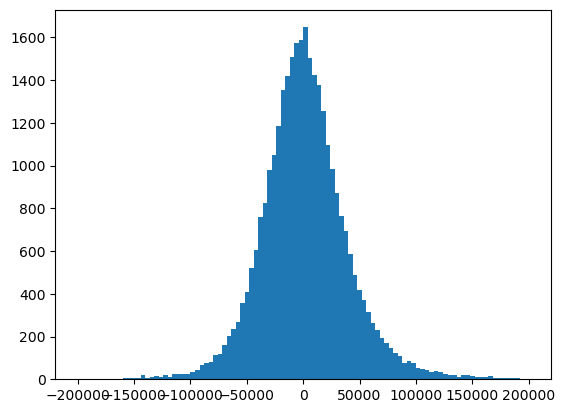

In [87]:
#Normalised check of the residuals of validation data
resids = df['y_valid'] - df['Predicted']
plt.hist(resids, bins=100, range=[-200000, 200000])
plt.show()

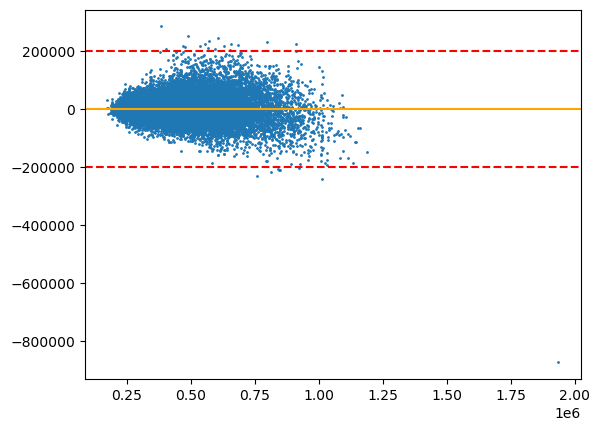

In [88]:
#Equal variance check of the residuals of validation data
plt.scatter(df['Predicted'], resids, s=1)
plt.axhline(0, color="orange")
plt.axhline(-200000, color="red", linestyle='--')
plt.axhline(200000, color="red", linestyle='--')

In [89]:
#Check the outliers of the residuals
outliers_index = df[(resids > 200000) | (resids < -200000)].index
df_train.loc[outliers_index,:]['flat_type'].value_counts()

4 ROOM       8
5 ROOM       8
3 ROOM       6
EXECUTIVE    4
Name: flat_type, dtype: int64

**Noted that the outliers are from 3 ROOM, 4 ROOM, 5 ROOM and EXECUTIVE. It indicates that Model_3, Model_4, Model_5 and Model_exec still need further improvement to effectively handle the outliers.**

# 6. Conclusion and Recommendation

## 6.1 Conclusion

We built 7 models for each flat type to predict the resale price, in overall with a **R2 score** of **0.928** and **RMSE** of **39,415.31**. Besides, we were able to identify the **top 5 features** that were **positively correlated** to the **resale price** for **each flat type**, as shown in the results below: 

|   |1 Room|2 Room|3 Room|4 Room|5 Room|Exec|Multi|
|---|---|---|---|---|---|---|---|
|**1st**|tranc_month|4room_sold|max_floor_lvl|max_floor_lvl|hawker_within_2km|hawker_within_2km|hawker_within_2km|
|**2nd**|mid_storey|floor_area_sqft|floor_area_sqft|hawker_within_2km|max_floor_lvl|hawker_within_1km|hawker_market_stalls|
|**3rd**|tranc_year|max_floor_lvl|mid_storey|hawker_within_1km|hawker_within_1km|floor_area_sqft|hawker_food_stalls|
|**4th**|-|mid_storey|hawker_within_2km|mid_storey|hawker_within_500m|hdb_age|hawker_within_1km|
|**5th**|-|mall_within_500m|mall_within_2km|hawker_within_500m|mid_storey|affiliation|floor_area_sqft|

Generally speaking, **max floor level**, **number of hawkers/malls within a certain distance**, **floor area** and **mid storey** are the top positively correlated features, however the order of correlation varies depending on different flat types. 

## 6.2 Recommendation

When considering purchasing an HDB resale flat, it's important to keep in mind that in general the **floor area** is typically the **most** significant factor affecting the resale price. Historical data shows same as common sense: larger flats tend to be more expensive. However, to get a more accurate estimate of what you can expect to pay, it's advisable to dive deeper into HDB transactions and pricing trends for **different flat types**.

For example, if you're looking to buy a **3 Room** or **4 Room** flat, you should pay close attention to the **maximum floor level** of the building as flats with higher maximum floor levels are often more expensive. On the other hand, if you're considering a **5 Room**, **Executive**, or **Multi-generation** flat, the **number of hawkers within 2km** is a key factor to consider. Historical data suggests that flats located in areas with more hawkers within 2km tend to command higher prices.

As a seller of an HDB resale flat, taking into account the information mentioned above can help you to maximize the value of your sale.

# 7. Limitations

During this exercise, several limitations were identified:

1. The linear relationship between the selected features in the dataset and the HDB resale price was weak, while the multicollinearity among the selected features was strong. This made it difficult to fit the data to a single linear model and interpret the coefficients effectively. To improve the interpretation of the resale price, it may be advisable to consider other features that have a stronger linear relationship with the resale price and more independent to each other.

2. Using different models for different flat types, the generalization of the model is limited. For instance, if HDB introduces a new flat type, the current models will not be applicable for prediction.

3. Models for 3 room, 4 room, 5 room and Executive still require further improvement, as they exhibit relatively high RMSE with outliers.

# 8. Future Steps

1. **Model Selection:** Rather than using different models for different flat types, a more generalized model can be used. For example, a decision tree-based algorithm such as random forests or gradient boosting could be applied, which can handle non-linear relationships between features and target variable.

2. **Model Improvement:** To improve the performance of models for 3 room, 4 room, 5 room and Executive, the outliers present in the data can be further analyzed to find out the reasons, try to either removed or imputed depending on their impact on the model performance.

3. **Data Collection:** To address the issue of the model's limited generalization, more data on different (or new) flat types can be collected and added to the dataset, which will improve the model's ability to generalize to different (or new) flat types.